# NODE A - UI

This notebook is designed to create a User Interface (UI) for interacting with a robot in a simulated environment. The UI allows users to set new targets for the robot, cancel goals, and visualize the robot's movements and goal statuses.


## Import necessary modules

We start by importing the necessary libraries for ROS, actionlib (for goal management), custom message types (ouass.msg), and visualization tools such as ipywidgets for the UI and matplotlib for plotting.

In [1]:
from __future__ import print_function
import sys    
import rospy
import actionlib
from ouass.msg import PlanningAction, PlanningGoal
from ouass.msg import RobotTarget
from ouass.msg import Data
from nav_msgs.msg import Odometry
from geometry_msgs.msg import PoseStamped
import time
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

## Enable interactive plotting in Jupyter Notebook

In [2]:
%matplotlib widget

## Initialize the ROS node, widgets, and variables

Here, we initialize the ROS node named 'UI' and set up some global variables:

- goalz: List to keep track of successful and failed goals.
- flag, changed: Variables to manage the state of goals and updates.

In [3]:
rospy.init_node('UI', anonymous=True)
goalz=[0,0]  # Array to keep track of goals: [unreached, reached]
flag = True
changed = False

## Setting Up Widgets

These widgets provide a UI for users to interact with the robot:

- x_text and y_text are for inputting new target coordinates.
- buttonChange, buttonCancel, and buttonSubmit are buttons for changing, canceling, and submitting goals respectively.
- text_reached and text_canceled display the number of reached and unreached targets.
- target_txt is a horizontal box containing the labels and text displays.

In [4]:
x_text = widgets.FloatText(description="X Coordinate:")
y_text = widgets.FloatText(description="Y Coordinate:")
buttonChange = widgets.Button(description="Change Target")
buttonCancel = widgets.Button(description="Cancel Target")
buttonSubmit = widgets.Button(description="Submit")

text_reached = widgets.Label()
text_canceled = widgets.Label()

label_reached = widgets.Label(value="Reached Targets:")
label_canceled = widgets.Label(value="Unreached Targets:")

target_txt = widgets.HBox([label_reached, text_reached, label_canceled, text_canceled])

## Widget update functions

These functions handle user interactions with the widgets:

- cancel(b): Cancels the current goal and updates the display.
- change_target(b): Prepares the UI for setting a new target.
- on_submit_clicked(b): Submits the new target coordinates, updates the goal counters, and publishes the new target.
- update_targets_txt(reached, canceled): Updates the text widgets showing the number of reached and unreached targets.

In [5]:
def cancel(b):
    client.cancel_goal()
    rospy.loginfo("Goal has been canceled\n")
    clear_output()
    display(buttonChange, buttonCancel)
    print("Goal has been canceled\n")

def change_target(b):
    clear_output()
    display(x_text, y_text, buttonSubmit)

def on_submit_clicked(b):
    global goalz
    x = x_text.value
    y = y_text.value
    
    goalz[0] += 1
    vis2.update_plot()
    
    last_target_msg = RobotTarget()
    last_target_msg.target_x = x
    last_target_msg.target_y = y
    
    pub.publish(last_target_msg)
    
    vis.last_targetcallback(last_target_msg)
    client.wait_for_server()
    
    goal = PoseStamped()
    goal.pose.position.x = x
    goal.pose.position.y = y
    
    goal = PlanningGoal(goal)
    
    client.send_goal(goal, done_cb=goal_done_cb)

    clear_output()
    display(buttonChange, buttonCancel)
    print(f"New goal has been set, x: {x}, y: {y}\n")

def update_targets_txt(reached, canceled):
    text_reached.value = str(reached)
    text_canceled.value = str(canceled)

## Call back functions

These functions handle callbacks for subscriber updates and goal status:

- subscriber_callback(data): Processes incoming odometry data and passes it to the visualizer.
- goal_done_cb(state, result): Updates the goal status and counters when a new target goal is set.

In [6]:
def subscriber_callback(data):
    msg = Data()
    
    msg.vel_x = data.twist.twist.linear.x 
    msg.vel_y = data.twist.twist.linear.y
    msg.position_x = data.pose.pose.position.x 
    msg.position_y = data.pose.pose.position.y 

    vis.odom_callback(data)
    
def goal_done_cb(state, result):
    global changed, flag, goalz
    if changed:
        if state == actionlib.GoalStatus.SUCCEEDED:
            if flag == True:
                goalz[0] -= 1
                goalz[1] += 1
                flag = False
        else:
            flag = True
    vis2.update_plot()  

# Visualiser class

This class handles the real-time plotting of the robot's position and the current goal position:

- __init__: Initializes the plot with position and goal markers.
- plot_init: Sets up the plot limits and aspect ratio.
- odom_callback: Appends new odometry data to the position lists.
- update_plot: Updates the plot with the latest position and goal data.
- last_targetcallback: Updates the goal position when a new target is set.

In [7]:
class Visualiser:
    def __init__(self, ax):
        self.ax = ax
        self.ln, = self.ax.plot([], [], 'ro', markersize=3, linestyle='-', linewidth=1, label='Position') 
        self.goal_ln, = self.ax.plot([], [], 'b+', label='Goal') 

        self.x_data, self.y_data = [], []
        self.x_goal, self.y_goal = [0], [0]

    def plot_init(self):
        self.ax.set_xlim(10, -10)
        self.ax.set_ylim(10, -10)
        
        self.ax.set_aspect('equal') 

        self.ax.legend()
        return self.ln, self.goal_ln

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)


    def update_plot(self, frame=0):
        global changed
        self.ln.set_data(self.x_data, self.y_data)
        if changed:
            self.goal_ln.set_data(self.x_goal, self.y_goal)
        return self.ln, self.goal_ln

    def last_targetcallback(self, msg):
        global changed
        changed = True
        self.x_goal = [msg.target_x]
        self.y_goal = [msg.target_y]

## Goal visualizer function

This class handles the pie chart visualization of successful and failed goals:

- __init__: Initializes the pie chart with initial values and labels.
- update_plot: Updates the pie chart with the latest goal counters and ensures the display is refreshed.

In [8]:
class GoalVisualizer:
    def __init__(self, ax):
        self.ax = ax
        self.labels = ['Successful', 'Failed']
        self.sizes = [0.001, 0.001]  
        self.colors = ['lightgreen', 'lightcoral']
        self.pie = self.ax.pie(self.sizes, labels=self.labels, colors=self.colors,
                        autopct='%1.1f%%', shadow=True, startangle=140)
        self.ax.axis('equal')  

    def update_plot(self, frame=0):
        global goalz
        self.sizes = [goalz[1], goalz[0]]

        if sum(self.sizes) == 0:
            self.sizes = [0.001, 0.001]

        self.ax.clear()

        self.pie = self.ax.pie(self.sizes, labels=self.labels, colors=self.colors,
                               autopct='%1.1f%%', shadow=True, startangle=140)
        self.ax.axis('equal')
        update_targets_txt(goalz[1], goalz[0])

## Show the UI

Here, we show the UI.

In [9]:
display(buttonChange, buttonCancel)

Button(description='Change Target', style=ButtonStyle())

Button(description='Cancel Target', style=ButtonStyle())

New goal has been set, x: 3.0, y: 3.0



## Visualizing the data

here initialize the visualizations:

- fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 5)): Creates a figure with two subplots for position and goal - visualizations.
- vis and vis2: Initialize the visualizer instances for position and goal visualizations.
- FuncAnimation: Set up animations for the visualizations to update them in real-time.
- update_targets_txt(0,0), display(target_txt): Initialize and display the target counters.

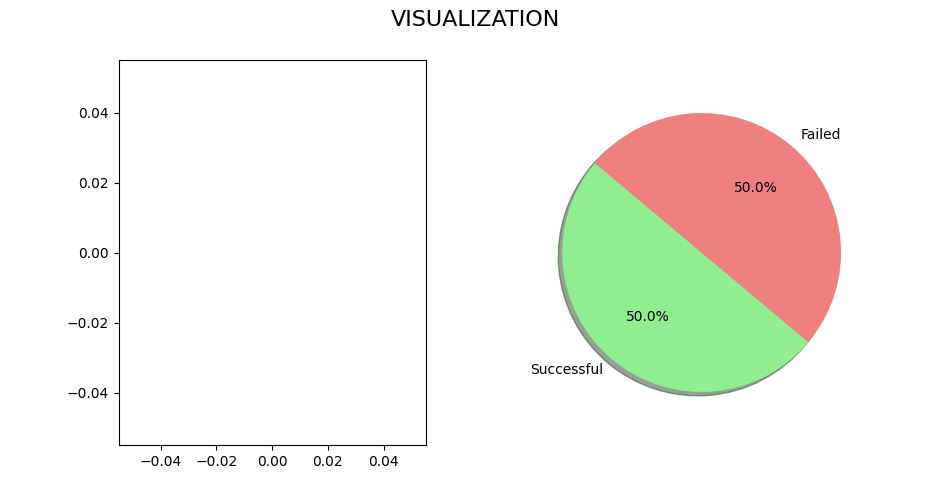

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 5))

vis = Visualiser(ax1)
vis2 = GoalVisualizer(ax2)

fig.suptitle('VISUALIZATION', fontsize=16)

plt.subplots_adjust(wspace=0.4)

ani = FuncAnimation(fig, vis.update_plot, init_func=vis.plot_init, frames=100, interval=100)
ani2 = FuncAnimation(fig, vis2.update_plot, frames=100, interval=100)

update_targets_txt(0,0);
display(target_txt)

## Setting functions for buttons and initialize clients, publishers, and subscribers

we set up the event handlers for the buttons and initialize the ROS action client, publisher, and subscriber:

- buttonChange.on_click(change_target): Registers the change target button click event.
- buttonCancel.on_click(cancel): Registers the cancel target button click event.
- buttonSubmit.on_click(on_submit_clicked): Registers the submit button click event.
- client: Initializes the action client to communicate with the /reaching_goal action server.
- pub: Initializes the publisher to send the latest target to the last_target topic.
- sub: Initializes the subscriber to listen to the /odom topic for odometry data.

In [11]:
buttonChange.on_click(change_target)
buttonCancel.on_click(cancel)
buttonSubmit.on_click(on_submit_clicked)

client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
pub = rospy.Publisher('last_target', RobotTarget, queue_size=10)
sub = rospy.Subscriber("/odom", Odometry, subscriber_callback)